# Score Matching with Langevin Dynamics (SMLD)

Score-based generative models is an another approach to generate data from a desired distribution.

In this tutorial, we'll see an earlier work for score-based generative model - Score Matching with Langevin Dynamics (SMLD).<br>
This method estimates and learns the score (the gradient of log probability density function with respect to data) with noised features in the training. In generation (inference) time, it then samples from a sequence (with large enough timesteps) of features decreasing noise by using Langevin dynamics.

> Note : SMLD is a prior work before previous DDPM. (DDPM is reported to achieve higher sample quality than SMLD.)<br>
> In order to prepare for the next chapter (score-based modeling through SDE), I'll discuss score-based modeling in this notebook after DDPM.

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture & Method

Let's briefly follow theoretical aspects behind Score Matching with Langevin Dynamics (SMLD) along with the original paper [[Song & Ermon, 2019](https://arxiv.org/pdf/1907.05600)].

First I introduce you Langevin equation which is used for sampling from a true distribution $p(\mathbf{x})$.<br>
You can produce samples by applying the following equation iteratively for $t=1, \ldots , T$.

$\displaystyle \mathbf{x}_t = \mathbf{x}_{t-1} + \tau \nabla_{\mathbf{x}_{t-1}} \log p(\mathbf{x}) + \sqrt{2 \tau}\mathbf{z} \;\;\;\;\;\; (1)$

where

- $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
- $\tau$ is a parameter for step size.
- $\mathbf{x}_0$ is randomly picked up.

This equation is derived in physics, which describes Brownian motion.<br>
From a perspective of mathematical view, this equation intuitively consists of gradient ascent plus noises. In this equation, the term of $\mathbf{x}_{t-1} + \tau \nabla_{\mathbf{x}_{t-1}} \log p(\mathbf{x})$ is a gradient ascent for the likelihood estimation, and the term of $\sqrt{2 \tau}\mathbf{z}$ is a noise (random walking).<br>
If it's far from the peak, it will be strongly pulled towards the peak by the gradient direction. If it's closer to the peak, it will move around (left and right) slightly.

As you can see results in the following experiments, you can pick up data samples following a true distribution $p(\mathbf{x})$ by applying Langevin equation with large enough timesteps $t$. (i.e., Large enough timesteps decreases noise to generate true distribution.)

![Applying Langevin experiments](./assets/langevin_experiments.png)

In terms of image generation, if we know a distribution for true image pixels $\mathbf{x}$, we can then generate image samples by applying Langevin dynamics.<br>
Now our concern is how to get $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ (in Langevin equation) for image generation tasks.

To make it possible, first let us define the following function $\mathbf{s}_{\theta}(\mathbf{x})$, called **(Stein's) score**. (In this example, I assume that the function $\mathbf{s}_{\theta}(\mathbf{x})$ is realized by a neural network.) :

$\displaystyle \mathbf{s}_{\theta}(\mathbf{x}) \stackrel{\mathrm{def}}{=} \nabla_{\mathbf{x}} \log p(\mathbf{x})$

where $\theta$ is a set of parameters of the function $\mathbf{s}(\cdot)$.

> Note : Please do not confuse with the ordinary score function used in maximum log-likelihood estimation (MLE), which is defined by : $\mathbf{s}_{\mathbf{x}}(\theta) \stackrel{\mathrm{def}}{=} \nabla_{\theta} \log p_{\theta}(\mathbf{x}) $

Now we want to estimate the following equation $J(\theta)$ in order to compute a loss between $\mathbf{s}_{\theta}(\mathbf{x})$ and $\nabla_{\mathbf{x}} \log p(\mathbf{x})$.<br>
But the difficulty of this problem is how to obtain $\nabla_{\mathbf{x}} \log p(\mathbf{x})$, because $p(\mathbf{x})$ is an unknown distribution. (This is the reason why the name implies "score-matching" problem.)

$\displaystyle J(\theta) = \frac{1}{2} \mathbb{E}_{p(\mathbf{x})} \left[ \| \mathbf{s}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \|^2 \right]$

There might have several approaches to solve this problem.<br>
For instance, you can take non-parametric approach to get the approximation of $p(\mathbf{x})$, such as, applying kernel density estimation discussed in [here](https://tsmatz.wordpress.com/2020/06/01/svm-and-kernel-functions-mathematics/) (this method is called Explicit Score Matching), but this method might have poor scalability, because it leads to large complexity when data is large.<br>
Another approach is an estimation technique (for non-normalized models) discussed in [[A Hyvärinen, 2005](https://jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)], but this might also be difficult to compute when the score function is realized by neural networks.

To overcome this issue, here we apply **Denoising Score Matching (DSM)** technique [[Vincent, 2010](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf)] as follows.

First we define pre-defined noise distribution $q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x})$ for image $\mathbf{x}$ where $\sigma$ is a set of parameters in noise distribution. The marginal perturbed data distribution $q_{\sigma}(\tilde{\mathbf{x}})$ can then be defined as follows by using the observed data point $\mathbf{x}$. :

$\displaystyle q_{\sigma}(\tilde{\mathbf{x}}) \stackrel{\mathrm{def}}{=} \int q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x}) p(\mathbf{x}) d\mathbf{x}$

Under this assumption, we try to employ score matching (i.e., computing $J(\theta)$) to estimate the score of this perturbed data distribution, and it's known (proved) that the objective is equivalent to minimizing the following equation. (See below note.) :

$\displaystyle J_{DSM}(\theta) = \frac{1}{2} \mathbb{E}_{q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x}) p(\mathbf{x})} \left[ \| \mathbf{s}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x}) \|^2 \right] \;\;\;\;\;\; (2)$

where $\mathbb{E}_{q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x}) p(\mathbf{x})}[\cdot]$ means the expectation under $\mathbf{x} \sim p(\mathbf{x})$ and $\tilde{\mathbf{x}} \sim q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x})$.

> Note : For the proof, see Appendix in [[Vincent, 2010](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf)].<br>
> When we denote a loss by kernel density estimation (i.e., Explicit Score Matching) as $J_{ESM}(\theta)$ ($\approx J(\theta)$), it's known (proved) that <br>
> $J_{DSM}(\theta) = J_{ESM}(\theta) + C$ <br>
> where $C$ is a constant which doesn't depend on $\theta$.

Now let us assume $q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}|\mathbf{x},\sigma^2)$.<br>
In this assumption, $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x})$ holds :

$\displaystyle \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x})$

$\displaystyle =\nabla_{\tilde{\mathbf{x}}} \log \frac{1}{(\sqrt{2\pi\sigma^2})^d} \exp \left\{ -\frac{\| \tilde{\mathbf{x}}-\mathbf{x} \|^2}{2\sigma^2} \right\}$

$\displaystyle =-\frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^2}$

where $d$ is the number of dimension.

Now we can let $\tilde{\mathbf{x}} = \mathbf{x} + \sigma \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.<br>
By substituting $\tilde{\mathbf{x}}$ and $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}|\mathbf{x})$ in the equation (2), the objective $J_{DSM}(\theta)$ can then be simplified as follows.

$\displaystyle J_{DSM}(\theta) = \mathbb{E}_{p(\mathbf{x})} \left[ \frac{1}{2} \left\| \mathbf{s}_{\theta}(\mathbf{x} + \sigma \mathbf{z}) + \frac{\mathbf{z}}{\sigma} \right\|^2 \right]$

This equation implies that $\mathbf{s}_{\theta}(\cdot)$ (which is the approximation of $\nabla_{\mathbf{x}} \log p(\mathbf{x})$) predicts the noise $-\mathbf{z} / \sigma$ when the noise $\mathcal{N}(\mathbf{0},\sigma^2 \mathbf{I})$ is added in the input.<br>
This is the reason why the name is "denoising" score-matching.

In order to generalize with a variety of $\sigma$ (variance), they propose to train (minimize) the following equation in the original paper. (See the original paper [[Song & Ermon, 2019](https://arxiv.org/pdf/1907.05600)] for details.)

- Pick up $\{\sigma_i\}_{i=1}^L$, where the sequence of noise satisfies $\sigma_1/\sigma_2 = \ldots = \sigma_{L-1} / \sigma_L > 1$.
- Instead of using $\mathbf{s}_{\theta}(\mathbf{x})$, use a single conditional score network $\mathbf{s}_{\theta}(\mathbf{x}, \sigma_i)$, in which the output depends on which $\sigma_i$ is applied for noising. This $\mathbf{s}_{\theta}(\mathbf{x}, \sigma_i)$ is called **Noise Conditional Score Network (NCSN)**. In this example, we will build $\mathbf{s}_{\theta}(\mathbf{x}, i)$ instead, in which we apply timestep embedding for the index $i$. (See the implementation later.)
- We then optimize parameter $\theta$ in NCSN to minimize the following loss.

$\displaystyle \frac{1}{L} \sum_{i=1}^L \sigma_i^2 \mathbb{E}_{p(\mathbf{x})} \left[ \frac{1}{2} \left\| \mathbf{s}_{\theta}(\mathbf{x} + \sigma_i \mathbf{z}, i) + \frac{\mathbf{z}}{\sigma_i} \right\|^2 \right] $

In the real training in which the size of batch is $M$, we will optimize $\theta$ to minimize the following loss insetad.

$\displaystyle \frac{1}{M} \sum_{n=1}^M \sigma_{i_n}^2 \mathbb{E}_{p(\mathbf{x})} \left[ \frac{1}{2} \left\| \mathbf{s}_{\theta}(\mathbf{x} + \sigma_{i_n} \mathbf{z}, {i_n}) + \frac{\mathbf{z}}{\sigma_{i_n}} \right\|^2 \right] $

where $i_n \in \{1,\ldots,L\}$.

For the inference (image generation) with NCSN, we then initialize $\mathbf{x}_0$ and apply the following equation for both $t=1, \ldots ,T$ and $i=1, \ldots ,L$ (i.e., nested loop).

$\displaystyle \mathbf{x}_t = \mathbf{x}_{t-1} + \frac{\alpha_i}{2} \mathbf{s}_{\theta}(\mathbf{x}_{t-1}, i) + \sqrt{\alpha_i}\mathbf{z}_t $

where $\alpha_i = \epsilon \cdot \sigma_i^2 / \sigma_L^2$ (step size with a scaling parameter $\epsilon$) and $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0},\mathbf{I})$

## Build and Train model

Now let's see the code (implementation) step-by-step with description of theoretical aspect.

> Note : See [here](https://github.com/ermongroup/ncsn) for official implementation.

Before we start, we need to install the required packages.

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm

### 1. Load data

We load images (CIFAR-10) dataset and dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [1]:
import torch
from torchvision import datasets, transforms

batch_size = 128

dataset = datasets.CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Now I show 100 examples.

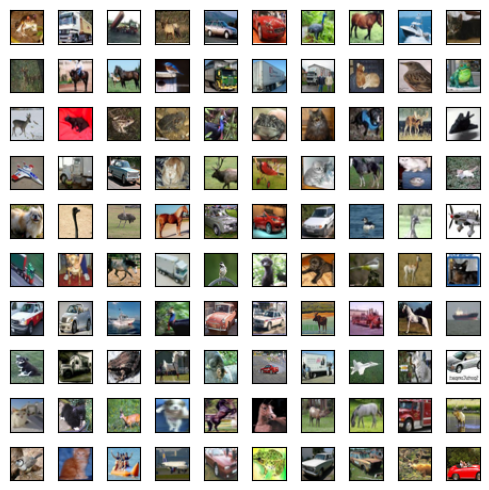

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    channel_last = np.transpose(i.numpy(), (1, 2, 0)) # (C, H, W) --> (H, W, C)
    plt.figure(figsize = (0.4,0.4))
    plt.imshow(channel_last)
    plt.show()
"""
num_row = 10
num_col = 10
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=num_row*num_col, shuffle=False)
for data, _ in tmp_loader:
    for i in range(num_row*num_col):
        image = data[i].numpy()
        channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(channel_last)
    break
plt.tight_layout()
plt.show()
del tmp_loader

### 2. Initialize $\{\sigma_i\}_{i=1}^L$

Now we initialize $\{\sigma_i\}_{i=1}^L$.

In order to make $\sigma_{i-1} / \sigma_i$ a constant ($>1$), we first create evenly spaced numbers and then calculate the exponentials of these numbers.

Here $\sigma_1$ is large enough such that $q_{\sigma_1}(\mathbf{x}) \approx \mathcal{N}(\mathbf{x}|\mathbf{0},\sigma_1^2\mathbf{I})$ and $\sigma_L$ is small enough such that $q_{\sigma_L}(\mathbf{x}) \approx p(\mathbf{x})$.<br>
According to the paper, Gaussian noise of $\sigma=0.01$ is almost indistinguishable to human eyes.

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import math

L = 10

seeds = torch.linspace(
    start=math.log(1.0),
    end=math.log(0.01),
    steps=L).to(device)
sigmas = torch.exp(seeds)
sigmas

tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100], device='cuda:0')

### 3. Build $\mathbf{s}_{\theta}$ (U-Net)

Now we build a NCSN, $\mathbf{s}_{\theta}(\mathbf{x}, \sigma_i)$.

In the original paper, the following U-Net architecture called **RefineNet** (a variant of U-Net) is engaged in this network.

Deep CNN, such as ResNet, has made a great success in computer vision. In the forward pass in ResNet, however, the resolution of features is dcreased, and low-resolution features will then lose important visual information captured in early stages.<br>
Dilated convolutions, on contrary, will solve this problem by maintaining the resolution of features in semantic segmentation. However the computaional cost will be increased by applying large dilated convolutions.<br>
RefineNet (a variant of U-Net) is developed to address these concerns in semantic segmentation.

![Entire architecture of RefineNet](./assets/refinenet_architecture.png)

You can see more details in the original paper of RefineNet, [[G. Lin, et. al., 2016](https://arxiv.org/pdf/1611.06612)].<br>
In SMLD, several modifications of this original RefineNet are made for implementing NCSN architecture. (See Appendix A in the paper [[Song & Ermon, 2019](https://arxiv.org/pdf/1907.05600)] for these modifications.)

> Note : Here we implement NCSN used in original paper, but you can use more improved architecture **NCSNv2** from [[Song & Ermon, 2020](https://arxiv.org/pdf/2006.09011)] and **NCSN++** from [[Song et. al., 2021](https://arxiv.org/pdf/2011.13456)] (see Appendix H in this paper).

Now let's see each building blocks in the implementation of RefineNet as follows.

**Conditional normalization**

Firstly, to realize a network conditioned on $\sigma_i$, we apply custom normalization conditioned on $\sigma_i$ in every convolutional layers and pooling layers.

In this custom conditional normalization, we intend to normalize $\mathbf{x}$ (which shape is [B,C,H,W]) by :

$\displaystyle \mathbf{y} = \frac{\mathbf{x} - E[\mathbf{x}]}{\sqrt{Var[\mathbf{x}] + \epsilon}} \gamma_i + \beta_i$

where $\gamma$ and $\beta$ are learnable parameters (of size C) conditioned on $i$ (the index of $\sigma$), and $\epsilon$ is a constant for numerical stability.

This conditioned normalization, however, doesn't include the information of the mean in each channel, and this normalization will then ignore the shifted colors in the input.<br>
To fix this problem, here we define the following conditioned normalization $\mathbf{y}$ instead.

In this definition, $E_1[\cdot]$ and $Var_1[\cdot]$ are location-wise mean and variance in a single channel. (i.e., $E_1[\cdot]$ and $Var_1[\cdot]$ are the same as $E[\cdot]$ and $Var[\cdot]$ in above equation.)<br>
On contrary, $E_2[\cdot]$ and $Var_2[\cdot]$ are the mean and variance of the mean of all locations (height and width) across channels in a single object. (See the below picture.)

$\displaystyle \mathbf{y} = \mathbf{h} \gamma_i + \beta_i$

$\displaystyle \mathbf{h} = \frac{\mathbf{x} - E_1[\mathbf{x}]}{\sqrt{Var_1[\mathbf{x}] + \epsilon}} + \frac{\mu - E_2[\mu]}{\sqrt{Var_2[\mu] + \epsilon}} \alpha_i$

where $\alpha$ is also a learnable parameter conditioned on $i$, and $\mu$ is the means of all locations in each channel.

![Elements in conditioned normalization](./assets/conditioned_normalization.png)

In [5]:
class CustomConditionalNormalization(nn.Module):
    def __init__(
        self,
        num_features,  # number of channels
        num_sigmas,    # number of sigma
        eps=1e-05,     # epsilon
    ):
        super().__init__()
        self.eps = eps
        self.get_alpha = nn.Embedding(
            num_sigmas,
            num_features,
        )
        self.get_beta = nn.Embedding(
            num_sigmas,
            num_features,
        )
        self.get_gamma = nn.Embedding(
            num_sigmas,
            num_features,
        )

        # The default weight's initialization in Embedding is N(0, 1).
        # To prevent large bias, we then initialize as follows.
        nn.init.normal_(self.get_alpha.weight, mean=1.0, std=0.02)
        nn.init.normal_(self.get_gamma.weight, mean=1.0, std=0.02)
        nn.init.zeros_(self.get_beta.weight)

    def forward(self, x, i):
        # normalize by E_1 and Var_1 --> shape: (B, C, H, W)
        norm1 = F.instance_norm(x, eps=self.eps)
        # normalize by E_2 and Var_2
        mu = torch.mean(x, dim=(2,3))                     # --> shape: (B, C)
        e2 = torch.mean(mu, dim=-1, keepdim=True)         # --> shape: (B, 1)
        var2 = torch.var(mu, dim=-1, keepdim=True)        # --> shape: (B, 1)
        norm2 = (mu - e2) / (torch.sqrt(var2 + self.eps)) # --> shape: (B, C)
        # get h
        alpha = self.get_alpha(i)                               # --> shape: (B, C)
        h = norm1 + norm2[:,:,None,None] * alpha[:,:,None,None] # --> shape: (B, C, H, W)
        # get output
        return h * self.get_gamma(i)[:,:,None,None] + self.get_beta(i)[:,:,None,None]

**Residual blocks (top-to-down path)**

Now we build residual blocks, which are used in top-to-down path of a network.

This blocks consists of residual convolutions, but in the last 2 layers, dilated convolutions are applied. (See above picture for the architecture.)<br>
In down-sampling on residual blocks, the image is divided into 4 blocks and then average-pooling is employed. (The height and width then becomes 1/2 respectively.)

I note that here all batch normalizations are replaced with above conditioned normalization.

> Note : In the original paper of RefineNet [[G. Lin, et. al., 2016](https://arxiv.org/pdf/1611.06612)], max-pooling is employed in pooling layers, but here we apply average-pooling instead. (This modifications are also applied in the following RefineNet blocks.)<br>
> For this reason, see Appendix A in the paper [[Song & Ermon, 2019](https://arxiv.org/pdf/1907.05600)].

In [6]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        input_dim,     # number of channels in input
        output_dim,    # number of channels in output
        num_sigmas,    # number of sigma
        dilation=None, # set the spacing between kernel points when applying dilated convolution
    ):
        super().__init__()

        self.norm1 = CustomConditionalNormalization(
            num_features=input_dim,
            num_sigmas=num_sigmas,
        )
        self.norm2 = CustomConditionalNormalization(
            num_features=output_dim,
            num_sigmas=num_sigmas,
        )
        if dilation is None:
            self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=1)
        else:
            self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=dilation, dilation=dilation)
            self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=dilation, dilation=dilation)

    def forward(self, x, i):
        out = self.norm1(x, i)
        out = F.elu(out)
        out = self.conv1(out)
        out = self.norm2(out, i)
        out = F.elu(out)
        out = self.conv2(out)
        return x + out

class DownsampleBlock(nn.Module):
    """The resolution (height and width) is halved respectively."""
    def __init__(
        self,
        input_dim,     # number of channels in input
        output_dim,    # number of channels in output
        num_sigmas,    # number of sigma
    ):
        super().__init__()

        self.norm1 = CustomConditionalNormalization(
            num_features=input_dim,
            num_sigmas=num_sigmas,
        )
        self.conv1 = nn.Conv2d(input_dim, input_dim, 3, stride=1, padding=1)
        self.norm2 = CustomConditionalNormalization(
            num_features=input_dim,
            num_sigmas=num_sigmas,
        )
        self.conv2 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=3 // 2)

        self.conv_residual = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=1, padding=1 // 2)

    def forward(self, x, i):
        out = self.norm1(x, i)
        out = F.elu(out)
        out = self.conv1(out)
        out = self.norm2(out, i)
        out = F.elu(out)
        out = self.conv2(out)
        # (In PyTorch, no dilation option in average pooling module, then implement by your own)
        out = torch.mean(torch.stack((out[:, :, ::2, ::2], out[:, :, 1::2, ::2], out[:, :, ::2, 1::2], out[:, :, 1::2, 1::2])), dim=0)

        x2 = self.conv_residual(x)
        x2 = torch.mean(torch.stack((x2[:, :, ::2, ::2], x2[:, :, 1::2, ::2], x2[:, :, ::2, 1::2], x2[:, :, 1::2, 1::2])), dim=0)
        return x2 + out

class DownsampleWithDilationBlock(nn.Module):
    """Unlike DownsampleBlock, the resolution (height and width) won't be changed."""
    def __init__(
        self,
        input_dim,     # number of channels in input
        output_dim,    # number of channels in output
        num_sigmas,    # number of sigma
        dilation,      # the spacing between kernel points
    ):
        super().__init__()

        self.norm1 = CustomConditionalNormalization(
            num_features=input_dim,
            num_sigmas=num_sigmas,
        )
        self.conv1 = nn.Conv2d(input_dim, input_dim, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm2 = CustomConditionalNormalization(
            num_features=input_dim,
            num_sigmas=num_sigmas,
        )
        self.conv2 = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=dilation, dilation=dilation)

        self.conv_residual = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=dilation, dilation=dilation)

    def forward(self, x, i):
        out = self.norm1(x, i)
        out = F.elu(out)
        out = self.conv1(out)
        out = self.norm2(out, i)
        out = F.elu(out)
        out = self.conv2(out)

        x2 = self.conv_residual(x)
        return x2 + out

**RefineNet blocks (bottom-to-up path)**

Now we'll build RefineNet block which is described in the original paper [[G. Lin, et. al., 2016](https://arxiv.org/pdf/1611.06612)]. (See the below picture.)

![RefineNet Block](./assets/refinenet_block.png)<br>
*From: "[RefineNet: Multi-Path Refinement Networks for High-Resolution Semantic Segmentation](https://arxiv.org/pdf/1611.06612)"*

In Residual Conv Unit (RCU), it applies residual convolutions twice for each inputs respectively.<br>
In multi-resolution fusion, it applies convolutions respectively for above results, and all results which might have different resolutions each other are sumed up into the same high-resolution (height and width) image. (See the following note)<br>
In chained residual pooling, it applies multiple pooling (followed by convolutions) in chained residual manner to capture background context from a large image region.

> Note : In above picture in the original paper [[G. Lin, et. al., 2016](https://arxiv.org/pdf/1611.06612)], Multi-resolution Fusion applies upsampling (which converts original resolution into high-resolution) respectively for inputs, and then sums up all these results. In this example, however, along with the [official implementation](https://github.com/ermongroup/ncsn), we don't apply upsampling and do apply interpolation to convert into high-resolution image in summing-up layer instead.

Here all batch normalizations in RefineNet architecture are also replaced with above conditioned normalization.

In [7]:
class RCUBlock(nn.Module):
    def __init__(
        self,
        num_features,  # number of channels (features)
        num_sigmas,    # number of sigma
        num_blocks,    # number of blocks to apply residual conv unit
    ):
        super().__init__()

        self.num_blocks = num_blocks
        self.num_stages = 2

        self.norms = nn.ModuleList([
            nn.ModuleList([
                CustomConditionalNormalization(
                    num_features=num_features,
                    num_sigmas=num_sigmas,
                )
                for _ in range(self.num_stages)])
            for _ in range(self.num_blocks)])
        self.convs = nn.ModuleList([
            nn.ModuleList([
                nn.Conv2d(
                    num_features,
                    num_features,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    bias=False,
                )
                for _ in range(self.num_stages)])
            for _ in range(self.num_blocks)])

    def forward(self, x, i):
        out_current = x
        for block in range(self.num_blocks):
            out_before = out_current
            for stage in range(self.num_stages):
                out_current = self.norms[block][stage](out_current, i)
                out_current = F.elu(out_current)
                out_current = self.convs[block][stage](out_current)
            out_current = out_current + out_before
        return out_current

class MultiResolutionFusionBlock(nn.Module):
    def __init__(
        self,
        input_dim_list, # the list of number of channels in input
        output_dim,     # number of channels in output
        num_sigmas,     # number of sigma
        resolution,     # resolution of tuple (height, width) to sum up
    ):
        super().__init__()

        self.output_dim = output_dim
        self.resolution = resolution
        self.num_inputs = len(input_dim_list)

        self.norms = nn.ModuleList([
            CustomConditionalNormalization(
                num_features=input_dim,
                num_sigmas=num_sigmas,
            )
            for input_dim in input_dim_list])
        self.convs = nn.ModuleList([
            nn.Conv2d(
                input_dim,
                output_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            )
            for input_dim in input_dim_list])

    def forward(self, x_list, i):
        batch_size = x_list[0].shape[0]

        # run as follows to save memory when len(self.num_inputs) is large
        sums = torch.zeros(batch_size, self.output_dim, self.resolution[0], self.resolution[1]).to(device)
        for idx in range(self.num_inputs):
            part = self.norms[idx](x_list[idx], i)
            part = self.convs[idx](part)
            part = F.interpolate(part, size=self.resolution, mode="bilinear", align_corners=True)
            sums = sums + part
        return sums

class ChainedResidualPoolingBlock(nn.Module):
    def __init__(
        self,
        num_features,  # number of channels (features)
        num_sigmas,    # number of sigma
    ):
        super().__init__()

        self.num_stages = 2

        self.norms = nn.ModuleList([
            CustomConditionalNormalization(
                num_features=num_features,
                num_sigmas=num_sigmas,
            )
            for _ in range(self.num_stages)])
        self.convs = nn.ModuleList([
            nn.Conv2d(
                num_features,
                num_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            )
            for _ in range(self.num_stages)])

    def forward(self, x, i):
        current = F.elu(x)
        sums = current
        for idx in range(self.num_stages):
            current = self.norms[idx](current, i)
            current = F.avg_pool2d(current, kernel_size=5, stride=1, padding=2)
            current = self.convs[idx](current)
            # (note: do not use += operation,
            #  because it's an inplace operation which modifies original content.)
            sums = current + sums
        return sums

class RefineNetBlock(nn.Module):
    def __init__(
        self,
        input_dim_list,     # the list of number of channels in input
        output_dim,         # number of channels in output
        num_sigmas,         # number of sigma
        resolution,         # resolution of tuple (height, width) for output
        num_final_blocks=1, # number of final output conv blocks
    ):
        super().__init__()

        self.num_inputs = len(input_dim_list)

        self.rcu = nn.ModuleList([
            RCUBlock(
                num_features=input_dim,
                num_sigmas=num_sigmas,
                num_blocks=2,
            )
            for input_dim in input_dim_list])
        if self.num_inputs > 1:
            self.mrf = MultiResolutionFusionBlock(
                input_dim_list=input_dim_list,
                output_dim=output_dim,
                num_sigmas=num_sigmas,
                resolution=resolution,
            )
        self.crp = ChainedResidualPoolingBlock(
            num_features=output_dim,
            num_sigmas=num_sigmas,
        )
        self.output_conv = RCUBlock(
            num_features=output_dim,
            num_sigmas=num_sigmas,
            num_blocks=num_final_blocks,
        )

    def forward(self, x_list, i):
        out = [self.rcu[n](x_list[n], i) for n in range(self.num_inputs)]
        if self.num_inputs > 1:
            out = self.mrf(out, i)
        else:
            out = out[0]
        out = self.crp(out, i)
        out = self.output_conv(out, i)
        return out

**Put them all together**

Finally we put them all together to build entire RefineNet network.

In [8]:
class UNet(nn.Module):
    def __init__(
        self,
        num_sigmas,         # number of sigma
    ):
        super().__init__()

        self.begin_conv = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)

        self.residual1 = nn.ModuleList([
            ResidualBlock(
                input_dim=128,
                output_dim=128,
                num_sigmas=L,
            ),
            ResidualBlock(
                input_dim=128,
                output_dim=128,
                num_sigmas=L,
            ),
        ])
        self.residual2 = nn.ModuleList([
            DownsampleBlock(
                input_dim=128,
                output_dim=256,
                num_sigmas=L,
            ),
            ResidualBlock(
                input_dim=256,
                output_dim=256,
                num_sigmas=L,
            ),
        ])
        self.residual3 = nn.ModuleList([
            DownsampleWithDilationBlock(
                input_dim=256,
                output_dim=256,
                num_sigmas=L,
                dilation=2,
            ),
            ResidualBlock(
                input_dim=256,
                output_dim=256,
                num_sigmas=L,
                dilation=2,
            ),
        ])
        self.residual4 = nn.ModuleList([
            DownsampleWithDilationBlock(
                input_dim=256,
                output_dim=256,
                num_sigmas=L,
                dilation=4,
            ),
            ResidualBlock(
                input_dim=256,
                output_dim=256,
                num_sigmas=L,
                dilation=4,
            ),
        ])

        self.refine4 = RefineNetBlock(
            input_dim_list=[256],
            output_dim=256,
            num_sigmas=L,
            resolution=(16,16),
        )
        self.refine3 = RefineNetBlock(
            input_dim_list=[256,256],
            output_dim=256,
            num_sigmas=L,
            resolution=(16,16),
        )
        self.refine2 = RefineNetBlock(
            input_dim_list=[256,256],
            output_dim=128,
            num_sigmas=L,
            resolution=(16,16),
        )
        self.refine1 = RefineNetBlock(
            input_dim_list=[128,128],
            output_dim=128,
            num_sigmas=L,
            resolution=(32,32),
            num_final_blocks=3,
        )

        self.end_norm = CustomConditionalNormalization(
            num_features=128,
            num_sigmas=num_sigmas,
        )
        self.end_conv = nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x, i):
        x = self.begin_conv(x)

        res1 = self.residual1[0](x, i)
        res1 = self.residual1[1](res1, i)
        res2 = self.residual2[0](res1, i)
        res2 = self.residual2[1](res2, i)
        res3 = self.residual3[0](res2, i)
        res3 = self.residual3[1](res3, i)
        res4 = self.residual4[0](res3, i)
        res4 = self.residual4[1](res4, i)

        out = self.refine4([res4], i)
        out = self.refine3([res3, out], i)
        out = self.refine2([res2, out], i)
        out = self.refine1([res1, out], i)

        out = self.end_norm(out, i)
        out = F.elu(out)
        out = self.end_conv(out)

        return out

In [9]:
#
# Generate model
#
unet = UNet(num_sigmas=L).to(device)

### 4. Train (Optimize) $\mathbf{s}_{\theta}$

Now let's train $\mathbf{s}_{\theta}$ (i.e, above RefineNet).

As we saw above, here we optimize $\theta$ to minimize the following loss.

$\displaystyle \frac{1}{M} \sum_{n=1}^M \sigma_{i_n}^2 \mathbb{E}_{p(\mathbf{x})} \left[ \frac{1}{2} \left\| \mathbf{s}_{\theta}(\mathbf{x} + \sigma_{i_n} \mathbf{z}, {i_n}) + \frac{\mathbf{z}}{\sigma_{i_n}} \right\|^2 \right] $

where $i_n \in \{1,\ldots,L\}$ and $M$ is the size of batch.

> Note : I have stopped the training with 600 epochs, but please run more to get more high quality samples.<br>
> The training requires a few days to complete with a single GPU.

In [10]:
import os

# initialize optimizer
opt = torch.optim.Adam(unet.parameters(), lr=0.001)

# remove log file if exists
log_file = "train_loss.log"
if os.path.exists(log_file):
    os.remove(log_file)

# loop
num_epochs = 600
for epoch_idx in range(num_epochs):
    epoch_loss = []
    for batch_idx, (data, _) in enumerate(loader):
        opt.zero_grad()

        # pick up x
        x = data.to(device)
        # apply 1/256 random noise
        x = (x * 255.0 + torch.rand_like(x).to(device)) / 256.0
        # pick up i
        b = x.size(dim=0)
        i = torch.randint(0, L, (b,)).to(device)
        # pick up z
        z = torch.randn_like(x).to(device)
        # get x + sigma_i * z
        sigma_i = sigmas[i][:,None,None,None]
        x_tilde = x + sigma_i * z
        # get model output by s_theta
        model_out = unet(x_tilde, i)
        # compute total loss
        loss = torch.sum((model_out + z / sigma_i)**2 * 0.5 * sigma_i**2, dim=(1,2,3))
        # compute average loss
        loss = torch.mean(loss, dim=0)

        # optimize
        loss.backward()
        opt.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")

    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss))
    with open(log_file, "a") as f:
        for l in epoch_loss:
            f.write("%s\n" %l)
    torch.save(unet.state_dict(), f"smld_refinenet_{epoch_idx}.pt")

print("Done")

epoch1 (iter391) - loss 652.8557
epoch2 (iter391) - loss 464.1782
epoch3 (iter391) - loss 338.6938
epoch4 (iter391) - loss 310.9598
epoch5 (iter391) - loss 298.8775
epoch6 (iter391) - loss 290.3036
epoch7 (iter391) - loss 286.1653
epoch8 (iter391) - loss 282.5522
epoch9 (iter391) - loss 283.4534
epoch10 (iter391) - loss 277.6743
epoch11 (iter391) - loss 279.3609
epoch12 (iter391) - loss 277.1851
epoch13 (iter391) - loss 275.7404
epoch14 (iter391) - loss 275.1467
epoch15 (iter391) - loss 274.0109
epoch16 (iter391) - loss 273.5557
epoch17 (iter391) - loss 274.4861
epoch18 (iter391) - loss 272.9755
epoch19 (iter391) - loss 271.5725
epoch20 (iter391) - loss 272.6253
epoch21 (iter391) - loss 273.1265
epoch22 (iter391) - loss 269.1345
epoch23 (iter391) - loss 269.7849
epoch24 (iter391) - loss 270.5508
epoch25 (iter391) - loss 269.7597
epoch26 (iter391) - loss 269.5147
epoch27 (iter391) - loss 268.3768
epoch28 (iter391) - loss 270.5117
epoch29 (iter391) - loss 269.3940
epoch30 (iter391) - los

Show loss transition of the first 10 epochs in training.

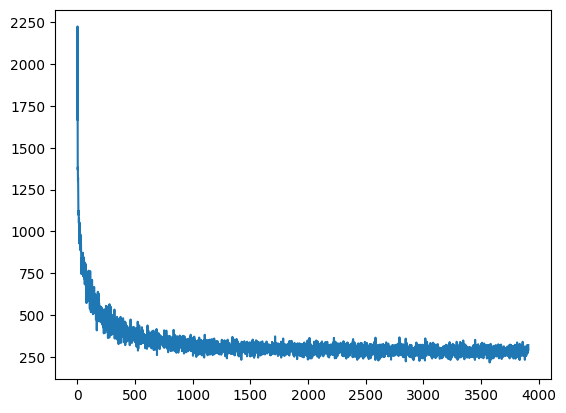

In [11]:
with open(log_file, "r") as f:
    all_loss = [float(line) for line in f]
num_rec = len(all_loss) * 10 // num_epochs
plt.plot(all_loss[:num_rec])

## Image generation with trained model

Now let's create images using above trained model (RefineNet).

As I have mentioned above, the image is generated by applying the following equation for both $t=1, \ldots ,T$ and $i=1, \ldots ,L$ (i.e., nested loop).

$\displaystyle \mathbf{x}_t = \mathbf{x}_{t-1} + \frac{\alpha_i}{2} \mathbf{s}_{\theta}(\mathbf{x}_{t-1}, i) + \sqrt{\alpha_i}\mathbf{z}_t $

where $\alpha_i = \epsilon \cdot \sigma_i^2 / \sigma_L^2$ (step size with a scaling parameter $\epsilon$) and $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

As you can see in this souce code, we use uniform noise for the initial samples.

I note that $\sigma_i$ (standard deviation) is reduced when $i$ grows in the iteration.

100%|████████████████████████████████████████████████████████████████| 10/10 [07:06<00:00, 42.66s/it]


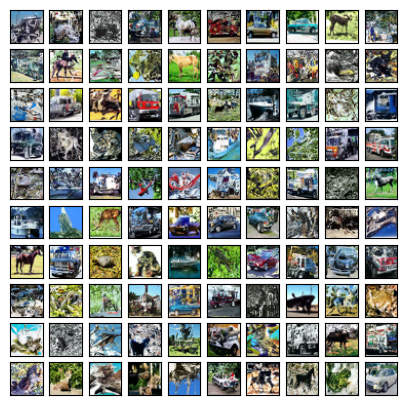

In [12]:
import tqdm

T = 100

def run_inference(unet, x_0, sigmas, T):
    x = x_0
    b = x_0.size(dim=0)
    with torch.no_grad():
        # (showing progress, because it needs a lot of time.)
        # for idx, sigma in enumerate(sigmas):
        for idx, sigma in tqdm.tqdm(enumerate(sigmas), total=len(sigmas)):
            i = torch.ones(b, dtype=int).to(device) * idx
            eps = 2e-5
            alpha = (sigma / sigmas[-1])**2*eps
            for t in range(T):
                model_out = unet(x, i)
                z = torch.randn_like(x).to(device)
                x = x + model_out*alpha*0.5 + z*torch.sqrt(alpha)
    # clip
    x = torch.clamp(x, min=0.0, max=1.0)
    return x

num_row = 10
num_col = 10

# initialize x_0
x_0 = torch.rand(num_row*num_col, 3, 32, 32).to(device)
# generate images
x = run_inference(unet, x_0, sigmas, T)
# draw
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
for i in range(num_row*num_col):
    image = x[i].cpu().numpy()
    channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
    row = i//num_col
    col = i%num_col
    ax = axes[row, col]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(channel_last)